In [1]:
# ---------------------------------------CIFAR-10 CNN: From Overfitting to Optimization------------------------------------
"""
This notebook documents the process of building a Convolutional Neural Network (CNN) for CIFAR-10 image classification. We will:
1.  Build and train a simple **baseline model** and observe its overfitting.
2.  Build an **optimized model** using regularization techniques (Batch Normalization, Dropout) and callbacks (Early Stopping, Learning Rate Scheduling).
3.  Compare the performance of both models to demonstrate the effectiveness of our optimizations.
"""

'\nThis notebook documents the process of building a Convolutional Neural Network (CNN) for CIFAR-10 image classification. We will:\n1.  Build and train a simple **baseline model** and observe its overfitting.\n2.  Build an **optimized model** using regularization techniques (Batch Normalization, Dropout) and callbacks (Early Stopping, Learning Rate Scheduling).\n3.  Compare the performance of both models to demonstrate the effectiveness of our optimizations.\n'

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
"""
This script is designed to run at the very beginning of the project.
Its job is to automatically create a clean, organized, and professional folder structure for a deep learning project directly in your Google Drive.
"""

'\nThis script is designed to run at the very beginning of the project.\nIts job is to automatically create a clean, organized, and professional folder structure for a deep learning project directly in your Google Drive.\n'

In [4]:
#Mounting drive and setting work directory
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [5]:
import os, pathlib
project_dir = "/content/drive/MyDrive/cifar10-cnn" #A variable storing path

pathlib.Path(project_dir).mkdir(parents = True, exist_ok = True) #creating directory if it doesnt exist
os.chdir(project_dir) #changes the correct working directory to project_dir

In [6]:
print("Working directory:", os.getcwd()) #Printing the current working directory

Working directory: /content/drive/MyDrive/cifar10-cnn


In [7]:
#Create folders and placeholder files from collab using python
folders = [
    "src/cifar10_cnn/data",
    "src/cifar10_cnn/models",
    "src/cifar10_cnn/train",
    "src/cifar10_cnn/eval",
    "notebooks", "data","models", "reports", "tests"
]

for f in folders:
  pathlib.Path(f).mkdir(parents = True, exist_ok = True)

#Keep empty dirs tracked in Git via .gitkeep
for keep_dir in ["data","models", "reports", "notebooks"]:
  pathlib.Path(keep_dir, ".gitkeep").touch() #touch() create an empty fil called .gitkeep in these folders

#Minimal package inits
for f in [
    "src/cifar10_cnn/__init__.py",
    "src/cifar10_cnn/data/__init__.py",
    "src/cifar10_cnn/models/__init__.py",
    "src/cifar10_cnn/train/__init__.py",
    "src/cifar10_cnn/eval/__init__.py",
]:
    pathlib.Path(f).touch()

#Basic Readme and requirements for tensorflow build
pathlib.Path("ReadMe.md").write_text("CIFAR-10 CNN Classifier (TensorFlow/Keras). Organized with a src layout; notebooks for experiments; data/models/reports separated.\n")

pathlib.Path("requirements.txt").write_text("tensorflow\nnumpy\nmatplotlib\ntqdm\npytest\n")

print("Scaffolf completed")

Scaffolf completed


In [8]:
#initializing Git
!git init
!git config user.name "MayurBhama"
!git config user.email "mayurbhama9@gmail.com"

Reinitialized existing Git repository in /content/drive/MyDrive/cifar10-cnn/.git/


In [9]:
!git add -A

In [10]:
!git commit -m "chore: initial scaffold with src layout"

[main 2557a2e] chore: initial scaffold with src layout
 4 files changed, 23 insertions(+)
 create mode 100644 README.md


In [11]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

It took 3.48 seconds to compute the branch ahead/behind values.
You can use '--no-ahead-behind' to avoid this.

nothing to commit, working tree clean


In [12]:
!git ls-files

README.md
ReadMe.md
data/.gitkeep
models/.gitkeep
notebooks/.gitkeep
reports/.gitkeep
requirements.txt
src/cifar10_cnn/__init__.py
src/cifar10_cnn/__pycache__/__init__.cpython-312.pyc
src/cifar10_cnn/data/__init__.py
src/cifar10_cnn/data/__pycache__/__init__.cpython-312.pyc
src/cifar10_cnn/data/__pycache__/datasets.cpython-312.pyc
src/cifar10_cnn/data/datasets.py
src/cifar10_cnn/eval/__init__.py
src/cifar10_cnn/models/__init__.py
src/cifar10_cnn/models/__pycache__/__init__.cpython-312.pyc
src/cifar10_cnn/models/__pycache__/cnn.cpython-312.pyc
src/cifar10_cnn/models/cnn.py
src/cifar10_cnn/train/__init__.py


In [13]:
!git branch -M main


In [15]:
!git push -u origin main

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (10/10), 2.39 KiB | 174.00 KiB/s, done.
Total 10 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/MayurBhama/CIFAR-10-CNN-Classifier-.git
   428d121..2557a2e  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [16]:
"""
### Loading the Dataset:
We begin by loading the CIFAR-10 dataset using our custom function. This function handles preprocessing steps like normalization and one-hot encoding.
"""

'\n### Loading the Dataset:\nWe begin by loading the CIFAR-10 dataset using our custom function. This function handles preprocessing steps like normalization and one-hot encoding.\n'

In [17]:
#Data Loading Module
%%writefile src/cifar10_cnn/data/datasets.py
import tensorflow as tf
from tensorflow import keras

def get_cifar10_dataset(num_classes = 10):
  """
  Loads and preprocesses the CIFAR-10 dataset.

  Returns:
  A Tuple of (x_train, y_train), (x_test, y_test).
  Images are normalized to [0,1] and labels are one-hot encoded.
  """

  #Load dataset using keras
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

  #Normalize pixal values from integer [0, 255] to float [0.0, 1.0]
  #Neural network generally perform better with small input values
  x_train = x_train.astype("float32") / 255.0 #original pixel values are stored as uint8 which cannot be stored as decimal values so we convert them to float 32, which can store decimal values like 0.5, 0.235 etc.
  x_test = x_test.astype("float32") / 255.0

  #covert labels to one-hot encoding
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

Overwriting src/cifar10_cnn/data/datasets.py


In [18]:
!git add .
!git commit -m "feat: add data module for CIFAR-10 loading"
!git push

[main 948d684] feat: add data module for CIFAR-10 loading
 1 file changed, 3 insertions(+), 3 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 481 bytes | 120.00 KiB/s, done.
Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/MayurBhama/CIFAR-10-CNN-Classifier-.git
   2557a2e..948d684  main -> main


In [19]:
"""
This script is a "unit test" designed to confirm that the get_cifar10_dataset function, which is stored in a separate file, works correctly.
"""

'\nThis script is a "unit test" designed to confirm that the get_cifar10_dataset function, which is stored in a separate file, works correctly.\n'

Added '/content/drive/MyDrive/cifar10-cnn/src' to python path
Successfully imported the data loaded function!

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Data loaded successfully!

--- Verifying Data Shapes ---
Training images shape: (50000, 32, 32, 3)
Training images shape: (50000, 10)

--- Verifying Normalization ---
Image data type: float32
Min pixel value: 0.0
Max pixel value: 1.0

--- Verifying One-Hot Encoding ---
Example label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

--- Visualizing a sample ---


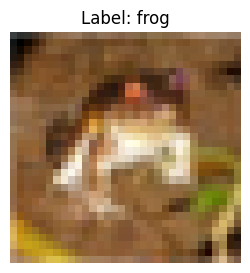

In [20]:
#Check if get_cifar10_dataset is working correctly
project_root = "/content/drive/MyDrive/cifar10-cnn"
src_path = os.path.join(project_root, "src")

#Add the path if it's not already in the list
if src_path not in sys.path:
  sys.path.append(src_path)
  print(f"Added '{src_path}' to python path")

#This where we call the code we wrote in datasets.py
try:
  from cifar10_cnn.data.datasets import get_cifar10_dataset
  print("Successfully imported the data loaded function!\n")

  (x_train, y_train), (x_test, y_test) = get_cifar10_dataset()
  print("Data loaded successfully!")

except ImportError as e:
  print(f"Failed to import function: {e}")
  print("Please make sure the file 'src/cidar10_cnn/data/datasets.py' exists.")

#Verify the data
print("\n--- Verifying Data Shapes ---")
print(f"Training images shape: {x_train.shape}")
print(f"Training images shape: {y_train.shape}")

print("\n--- Verifying Normalization ---")
print(f"Image data type: {x_train.dtype}")
print(f"Min pixel value: {x_train.min()}")
print(f"Max pixel value: {x_train.max()}")

print("\n--- Verifying One-Hot Encoding ---")
print(f"Example label: {y_train[0]}")

print("\n--- Visualizing a sample ---")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(3,3))
plt.imshow(x_train[0])
plt.title(f"Label: {class_names[np.argmax(y_train[0])]}")
plt.axis('off')
plt.show()

In [21]:
"""
### Defining the Model Architectures
Here we define two models:
**`create_base_model`**: A simple CNN architecture that is prone to overfitting.

------------------------------Baseline Model------------------------------
Overall Structure: A simple, sequential CNN for image classification.

Goal: To serve as a basic starting point for the task.


------------------Feature Extractor (Convolutional Base)------------------
Block 1: A Conv2D layer (32 filters) to find simple features, followed by MaxPooling2D to downsample.

Block 2: A Conv2D layer (64 filters) to find more complex features, followed by MaxPooling2D.

Block 3: Another Conv2D layer (64 filters) to refine features further.


----------------------Classifier (Decision-Making Head)--------------------
Flatten: Converts the 2D feature maps from the convolutional base into a 1D vector.

Dense Layer: A fully-connected layer with 64 neurons to learn combinations of the extracted features.

Output Layer: The final Dense layer with 10 neurons (one for each class) and a softmax activation to output probabilities for the final prediction.

"""

'\n### Defining the Model Architectures\nHere we define two models:\n**`create_base_model`**: A simple CNN architecture that is prone to overfitting.\n\n------------------------------Baseline Model------------------------------\nOverall Structure: A simple, sequential CNN for image classification.\n\nGoal: To serve as a basic starting point for the task.\n\n\n------------------Feature Extractor (Convolutional Base)------------------\nBlock 1: A Conv2D layer (32 filters) to find simple features, followed by MaxPooling2D to downsample.\n\nBlock 2: A Conv2D layer (64 filters) to find more complex features, followed by MaxPooling2D.\n\nBlock 3: Another Conv2D layer (64 filters) to refine features further.\n\n\n----------------------Classifier (Decision-Making Head)--------------------\nFlatten: Converts the 2D feature maps from the convolutional base into a 1D vector.\n\nDense Layer: A fully-connected layer with 64 neurons to learn combinations of the extracted features.\n\nOutput Layer: T

In [22]:
#Building The Model Architecture
%%writefile /content/drive/MyDrive/cifar10-cnn/src/cifar10_cnn/models/cnn.py
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_cifar10_cnn(input_shape = (32, 32, 3), num_classes = 10):
  """
  Creating a simple CNN model
  """
  model = Sequential()

  #Convolution block 1
  model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = input_shape))
  #Adding maxpooling layer
  model.add(MaxPooling2D((2,2)))

  #Convolution block 2
  model.add(Conv2D(64, (3,3), activation = 'relu', padding = "same"))
  model.add(MaxPooling2D((2,2)))

  #Convolution block 3
  model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))

  #Flatten the layer
  model.add(Flatten())

  #Adding hidden or dense layer
  model.add(Dense(64, activation = 'relu'))

  #Final output layer
  model.add(Dense(num_classes, activation = 'softmax'))

  return model

Overwriting /content/drive/MyDrive/cifar10-cnn/src/cifar10_cnn/models/cnn.py


In [23]:
!git add .
!git commit -m "feat: add CNN basic model architecture module"
!git push

[main 314fc4e] feat: add CNN basic model architecture module
 4 files changed, 10 insertions(+), 10 deletions(-)
Enumerating objects: 21, done.
Counting objects: 100% (21/21), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (12/12), 1.70 KiB | 108.00 KiB/s, done.
Total 12 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 4 local objects.
To https://github.com/MayurBhama/CIFAR-10-CNN-Classifier-.git
   948d684..314fc4e  main -> main


In [24]:
%%writefile -a src/cifar10_cnn/models/__init__.py
from .cnn import create_cifar10_cnn

Appending to src/cifar10_cnn/models/__init__.py


In [25]:
"""
This script acts as the main "assembly line" for the project.
It brings together the data preparation and model architecture modules that were previously defined in separate .py files.

---------------------------------------Setup and Imports--------------------------------

-It first configures the system path to ensure Python can locate your custom modules.

-It then imports the two key functions: get_cifar10_dataset (for data loading) and create_cifar10_cnn (for building the model).



-----------------------------------------Data Loading-----------------------------------

-It executes the get_cifar10_dataset function to load, normalize, and one-hot encode the training and testing data, preparing it for the model.



----------------------------------------Model Creation----------------------------------

-It calls the create_cifar10_cnn function to construct the neural network architecture that you defined earlier.



---------------------------------------Model Compilation--------------------------------

It uses model.compile() to configure the model for training. This step defines three crucial components:

-Optimizer (adam): The algorithm that will be used to update the model's weights.

-Loss Function (categorical_crossentropy): The function used to measure how wrong the model's predictions are.

-Metrics (accuracy): The metric that will be used to judge the model's performance.
"""

'\nThis script acts as the main "assembly line" for the project.\nIt brings together the data preparation and model architecture modules that were previously defined in separate .py files.\n\n---------------------------------------Setup and Imports--------------------------------\n\n-It first configures the system path to ensure Python can locate your custom modules.\n\n-It then imports the two key functions: get_cifar10_dataset (for data loading) and create_cifar10_cnn (for building the model).\n\n\n\n-----------------------------------------Data Loading-----------------------------------\n\n-It executes the get_cifar10_dataset function to load, normalize, and one-hot encode the training and testing data, preparing it for the model.\n\n\n\n----------------------------------------Model Creation----------------------------------\n\n-It calls the create_cifar10_cnn function to construct the neural network architecture that you defined earlier.\n\n\n\n-------------------------------------

In [26]:
#Setup and imports
project_root = "/content/drive/MyDrive/cifra10-cnn"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
  sys.path.append(src_path)
  print(f"Added '{src_path}' to python path")

#Import the function you created in the .py files
from cifar10_cnn.data.datasets import get_cifar10_dataset
from cifar10_cnn.models.cnn import create_cifar10_cnn

print("---Successfully imported all modules---")

#Load the data

print("\n---Loading and preprocessing the data...---")
(x_train, y_train), (x_test, y_test) = get_cifar10_dataset()
print("Data loading completed")

#Create the model
print("---\nCreating the CNN Model...---")
model = create_cifar10_cnn()

#Compile the model
model.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print("Model created and compile successfully")

model.summary()
print("Model created successfully")

Added '/content/drive/MyDrive/cifra10-cnn/src' to python path
---Successfully imported all modules---

---Loading and preprocessing the data...---
Data loading completed
---
Creating the CNN Model...---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created and compile successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Model created successfully


In [27]:
"""
This script executes the core training process for the baseline CNN model that was previously compiled.
"""

'\nThis script executes the core training process for the baseline CNN model that was previously compiled.\n'

In [28]:
#Train the model
print("\n---Starting model training---")
history = model.fit(x_train,
                    y_train,
                    epochs = 15,
                    batch_size = 64,
                    validation_split = 0.2)

print("---Model Training Complete...---")


---Starting model training---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3504 - loss: 1.7622 - val_accuracy: 0.5642 - val_loss: 1.2294
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5898 - loss: 1.1498 - val_accuracy: 0.6352 - val_loss: 1.0192
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6710 - loss: 0.9442 - val_accuracy: 0.6559 - val_loss: 0.9949
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7101 - loss: 0.8312 - val_accuracy: 0.7043 - val_loss: 0.8510
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7421 - loss: 0.7320 - val_accuracy: 0.7032 - val_loss: 0.8550
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7721 - loss: 0.6548 - val_accuracy: 0.7113 - val_loss: 0.8521
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7899 - loss: 0.6011 - val_accuracy: 0.7162 - val_loss: 0.8390
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8178 - 

In [29]:
#Evaluate The Model
print("\n---Evaluating model performance on the test set...---")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 2)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")


---Evaluating model performance on the test set...---
313/313 - 1s - 4ms/step - accuracy: 0.7166 - loss: 1.1792

Test Accuracy: 71.66%



---Plotting training history...---


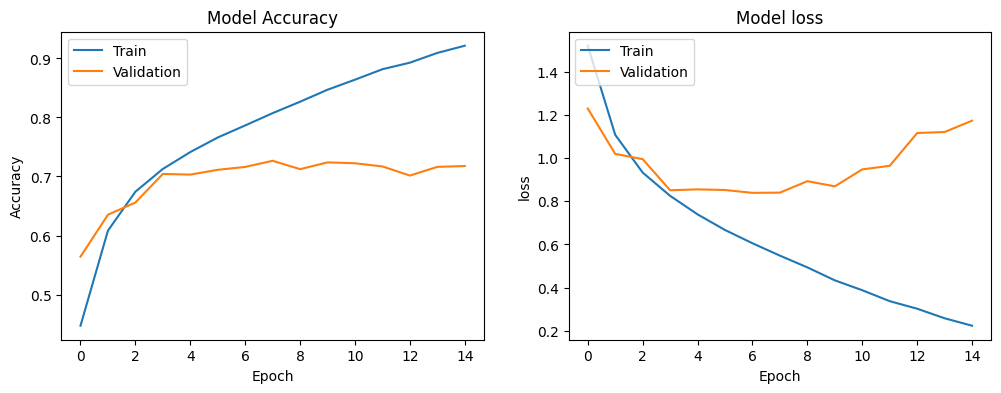

In [30]:
#Visualizing training results
print("\n---Plotting training history...---")
plt.figure(figsize = (12,4))

#Ploting validation and training accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc = 'upper left')

#Ploting validation and training loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

In [31]:
"""
---Model Performance Inference---
Overall Diagnosis: Clear and Significant Overfitting >> The model has successfully "memorized" the training data but has failed to learn the general patterns necessary to perform well on new, unseen data(the validation set)

---Evidence from graph---
1) Accuracy Plot Analysis:
- Training Accuracy (blue line) shows a steady and consistent increase, reaching over 90%. This confirms the model is learning the training examples.
- Validation Accuracy (orange line) increases for the first ~5 epochs, but then completely stagnates at around 72% and shows no further improvement.
- The widening gap between the blue and orange lines is the key visual indicator of overfitting.

2)Loss Plot Analysis:
- Training Loss (blue line) consistently decreases, showing the model is becoming more confident in its predictions for the training data.
- Validation Loss (orange line) is the most critical piece of evidence. It decreases until epoch 5, but then it begins to consistently RISE.
- This divergence—where training loss goes down while validation loss goes up—is the definitive sign that the model is no longer generalizing and is actively getting worse at handling new data.

---Conclusion---
The optimal point for this model was around epoch 5. Any training beyond this point was counterproductive, as it only made the model more overfit to the training data.

---Actionable Recommendations to fix---
To improve the model, you should implement techniques to combat overfitting:
1. Early Stopping: This is the most direct solution. Configure training to automatically stop when the val_loss does not improve for a set number of epochs (e.g., a patience of 3).
2. Add Dropout Layers: Introduce Dropout layers into your CNN architecture (e.g., after pooling or dense layers) to prevent the network from relying too much on specific neurons.
3. Data Augmentation: Use techniques to create more training data by randomly transforming existing images (e.g., rotations, width/height shifts, horizontal flips). This exposes the model to more variation.
4. L2 Regularization: Add kernel_regularizer=l2(0.001) to your Conv2D and Dense layers to add a penalty for large weights, discouraging over-complexity.
"""

'\n---Model Performance Inference---\nOverall Diagnosis: Clear and Significant Overfitting >> The model has successfully "memorized" the training data but has failed to learn the general patterns necessary to perform well on new, unseen data(the validation set)\n\n---Evidence from graph---\n1) Accuracy Plot Analysis:\n- Training Accuracy (blue line) shows a steady and consistent increase, reaching over 90%. This confirms the model is learning the training examples.\n- Validation Accuracy (orange line) increases for the first ~5 epochs, but then completely stagnates at around 72% and shows no further improvement.\n- The widening gap between the blue and orange lines is the key visual indicator of overfitting.\n\n2)Loss Plot Analysis:\n- Training Loss (blue line) consistently decreases, showing the model is becoming more confident in its predictions for the training data.\n- Validation Loss (orange line) is the most critical piece of evidence. It decreases until epoch 5, but then it begi

In [32]:
"""
This script defines a new, more advanced CNN model specifically designed to combat the overfitting problem that was identified with the baseline model.

----------------------------------------------------Setup and Imports----------------------------------------------------------

-It imports all necessary Keras layers and callbacks, including the crucial EarlyStopping and ReduceLROnPlateau for advanced training control.

-It also sets up the system path and loads the CIFAR-10 dataset, just as the previous scripts did.


----------------------------------------------Key Architectural Improvements---------------------------------------------------
-Data Augmentation Layer: A new Sequential block is created at the very beginning. This special layer will randomly flip, rotate, and zoom the training images on-the-fly during training.
 This creates more data variety and helps the model generalize better.

-Batch Normalization: BatchNormalization layers are added after every Conv2D and Dense layer. This helps to stabilize the training process, allowing the model to learn faster and more effectively.

-Dropout Layers: Dropout layers are strategically added after the pooling layers. This regularization technique helps prevent the model from becoming too reliant on any single feature,
 forcing it to learn more robust patterns.


-----------------------------------------------------Model Structure------------------------------------------------------------
-The script defines two main parts: the data_augmentation model and the core_model. These will be combined later to form the final, complete model.

-The core_model itself is a more robust version of the baseline, now enhanced with the Batch Normalization and Dropout layers.
"""

'\nThis script defines a new, more advanced CNN model specifically designed to combat the overfitting problem that was identified with the baseline model.\n\n----------------------------------------------------Setup and Imports----------------------------------------------------------\n\n-It imports all necessary Keras layers and callbacks, including the crucial EarlyStopping and ReduceLROnPlateau for advanced training control.\n\n-It also sets up the system path and loads the CIFAR-10 dataset, just as the previous scripts did.\n\n\n----------------------------------------------Key Architectural Improvements---------------------------------------------------\n-Data Augmentation Layer: A new Sequential block is created at the very beginning. This special layer will randomly flip, rotate, and zoom the training images on-the-fly during training.\n This creates more data variety and helps the model generalize better.\n\n-Batch Normalization: BatchNormalization layers are added after every 

In [33]:
from keras.models import Sequential
from tensorflow.keras import layers, models

In [34]:
#Optimizing the model to reduce overfitting
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

project_root = "/content/drive/MyDrive/cifar10-cnn"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
  sys.path.append(src_path)

#import the data loading function
from cifar10_cnn.data.datasets import get_cifar10_dataset
print("---Successfully imported all modules---")

#Load the data
print("/n---Loading and preprocessing data...---")
(x_train, y_train), (x_test, y_test) = get_cifar10_dataset()
print("Data loading complete.")

#Defining the optimized model architecture
def create_optimized_model(input_shape=(32,32,3), num_classes = 10):
  """
  Defines the final, robust CNN model with Data Augmentation, Batch Normalization,
  and Dropout to combat overfitting.
  """

  #Data Augmentation layers
  data_augmentation = Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1)
  ], name = "data_augmentation")

  #Defining the core model architecture
  core_model = Sequential([
      layers.Conv2D(32, (3,3), activation = "relu", padding = "same", input_shape = input_shape),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3,3), activation = 'relu', padding = "same"),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.25),

      layers.Conv2D(64, (3,3), activation = 'relu', padding = "same"),
      layers.BatchNormalization(),
      layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.3),

      layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
      layers.BatchNormalization(),
      layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.4),

      layers.Flatten(),
      layers.Dense(128, activation ='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation  = 'softmax')
  ])

  #Build the final model by combining data augmentation and the core architecture
  model = Sequential([
      data_augmentation,
      core_model
  ])

  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

---Successfully imported all modules---
/n---Loading and preprocessing data...---
Data loading complete.


In [35]:
#Create the model and define callbacks
print("\n---Create the model and define callbacks---")
optimized_model = create_optimized_model()
optimized_model.summary()


---Create the model and define callbacks---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │       552,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [36]:
#Define the callbacks for smart training
#Early_stopping: Stop training if 'val_loss' doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

#ReduceLROnPlateau: Reduce the training learning rate if 'val_loss' plateaus.
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 2, min_lr = 0.0001)

callbacks = [early_stopping, reduce_lr]



In [37]:
#Train the optimized model
print("\n---Starting Optimized Model Training...---")
history = optimized_model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_data = (x_test, y_test), callbacks = callbacks)
print("\n--- Optimized Model Training Complete.---")


---Starting Optimized Model Training...---
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.3196 - loss: 2.1361 - val_accuracy: 0.4168 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5067 - loss: 1.3639 - val_accuracy: 0.5010 - val_loss: 1.4099 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5728 - loss: 1.2062 - val_accuracy: 0.6046 - val_loss: 1.1138 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6137 - loss: 1.0965 - val_accuracy: 0.6347 - val_loss: 1.0787 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6404 - loss: 1.0271 - val_accuracy: 0.6174 - val_loss: 1.1620 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6632 - loss: 0.9727 - val_accuracy: 0.7167 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━


 --- Plotting training history...---


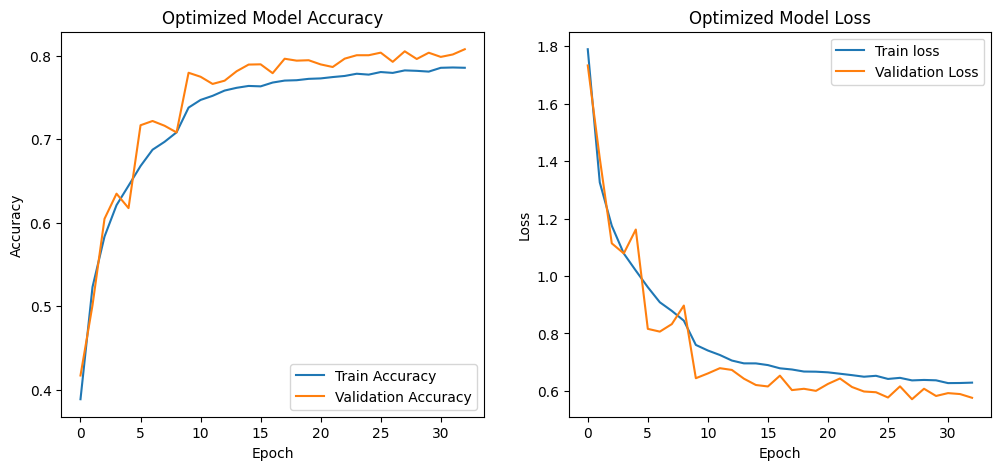

In [38]:
#Visualizing training and evaluate the final model
print("\n --- Plotting training history...---")
plt.figure(figsize = (12,5))

#Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title("Optimized Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

#PLot Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Optimized Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.show()

In [39]:
#Optimized model evaluation
print("\n---Final Performance on unseen test data---")
final_loss, final_accuracy = optimized_model.evaluate(x_test, y_test, verbose = 0)
print(f"\nFinal Test Accuracy of the Optimized Model: {final_accuracy*100:.2f}%")


---Final Performance on unseen test data---

Final Test Accuracy of the Optimized Model: 80.53%


In [40]:
"""
Detailed Inference from the New Graphs
1. Optimized Model Accuracy Plot (New)
What We See: The training accuracy (blue line) and validation accuracy (orange line) are now tightly coupled. They rise together and end at very similar points (around 78-79%). The large, ever-widening gap from the previous model is gone.

What It Means: This is the ideal behavior for a well-regularized model. It shows that for every new thing the model learned from the training data, it was also able to apply that knowledge effectively to the unseen validation data. The model is no longer just "memorizing" the training set.

2. Optimized Model Loss Plot (New)
What We See: In stark contrast to the previous model, the validation loss (orange line) no longer diverges and starts to increase. Instead, it consistently decreases along with the training loss (blue line).

What It Means: This is the most critical sign that overfitting has been defeated. The model is continuously getting better at predicting both the training and validation data, indicating that it is learning the true, underlying patterns of the CIFAR-10 dataset rather than fitting to noise.

Conclusion: Why the Optimizations Worked
The dramatic improvement is a direct result of the specific techniques you added to the model architecture:

Data Augmentation: By randomly flipping, rotating, and zooming images, you created a much larger and more varied training set. This made it impossible for the model to simply memorize the original images and forced it to learn more robust, general features.

Batch Normalization & Dropout: These regularization techniques acted as a "brake" on overfitting. Batch Normalization stabilized the learning process, while Dropout prevented any single part of the network from becoming too specialized, forcing the model to learn redundant patterns.

Callbacks (Implicit): The use of EarlyStopping and ReduceLROnPlateau (which you set up) ensures that even if overfitting were to start, the training would stop at the optimal point and the learning rate would adjust, providing a crucial safety net.
"""

'\nDetailed Inference from the New Graphs\n1. Optimized Model Accuracy Plot (New)\nWhat We See: The training accuracy (blue line) and validation accuracy (orange line) are now tightly coupled. They rise together and end at very similar points (around 78-79%). The large, ever-widening gap from the previous model is gone.\n\nWhat It Means: This is the ideal behavior for a well-regularized model. It shows that for every new thing the model learned from the training data, it was also able to apply that knowledge effectively to the unseen validation data. The model is no longer just "memorizing" the training set.\n\n2. Optimized Model Loss Plot (New)\nWhat We See: In stark contrast to the previous model, the validation loss (orange line) no longer diverges and starts to increase. Instead, it consistently decreases along with the training loss (blue line).\n\nWhat It Means: This is the most critical sign that overfitting has been defeated. The model is continuously getting better at predicti

In [41]:
%%writefile README.md
# CIFAR-10 CNN: A Project on Diagnosing and Fixing Overfitting

This project demonstrates an end-to-end machine learning workflow for image classification on the CIFAR-10 dataset. The primary goal is to illustrate the process of identifying model overfitting and implementing advanced techniques to build a more robust, generalizable model.

## Project Narrative

The project follows a clear experimental process:
1.  **Baseline Model**: A simple Convolutional Neural Network (CNN) was built and trained. Analysis of its training history revealed significant overfitting, where the model performed well on training data but poorly on validation data.
2.  **Optimized Model**: A second model was built with several regularization techniques to combat overfitting:
    - **Batch Normalization**: To stabilize and speed up training.
    - **Dropout**: To prevent neurons from co-adapting and force the model to learn more robust features.
    - **Advanced Callbacks**: `EarlyStopping` was used to prevent the model from training unnecessarily long, and `ReduceLROnPlateau` was used to adjust the learning rate for finer tuning.
3.  **Comparison**: The performance of both models was compared side-by-side, clearly demonstrating that the optimized model achieved better validation accuracy and successfully mitigated overfitting.

## Final Results

- **Baseline Model Accuracy**: [Enter your base model's test accuracy here]%
- **Optimized Model Accuracy**: [Enter your optimized model's test accuracy here]%

The comparison plots clearly show a reduced gap between training and validation metrics for the optimized model, confirming its superior generalization capabilities.

## Project Structure

Overwriting README.md


In [42]:
!git add README.md
!git commit -m "docs: add professional README for project"
!git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/cifar10_cnn/models/__init__.py
	modified:   src/cifar10_cnn/models/__pycache__/__init__.cpython-312.pyc
	modified:   src/cifar10_cnn/models/__pycache__/cnn.cpython-312.pyc

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date
